# 以101_20739为例制作误差图

In [11]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [12]:
import os
os.sys.executable


'd:\\Program\\Anaconda3\\envs\\Predict\\python.exe'

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [14]:
#df = pd.read_csv('../dataset/GOOG-year.csv')
ori_data=pd.read_csv("order_train1.csv",encoding='utf-8')
ori_data.head()
out=pd.read_csv("predict_sku_day.csv",encoding='utf-8')
out.head()

,sales_region_code,item_code,first_cate_code,second_cate_code
0,101,22025,306,407
1,101,22027,306,402
2,101,22028,305,412
3,101,22030,307,403
4,101,22035,305,412


In [15]:
# test_size = 101 # 预测未来3个月
simulation_size = 5 # 重复次数

In [16]:
# 参数设置
num_layers = 1          # LSTM单元个数
size_layer = 128        # 一层神经网络中的中神经元个数
timestamp = 5           # 时间步（从过去X天预测未来1天）
epoch = 150            # 迭代次数
dropout_rate = 0.8      # 跳出参数--防止过拟合
learning_rate = 0.01    # 学习率

In [17]:
# LSTM模型
class Model:
    def __init__(
        self,
        learning_rate,  # 学习率
        num_layers,     # LSTM单元个数
        size,           # 输入神经元个数
        size_layer,     # LSTM单层神经网络中的神经元个数
        output_size,    # 输出神经元个数（预测值）
        forget_bias = 0.1, # 忘记门指数
    ):
        # ———————————————————定义神经网络————————————————————————————
        def lstm_cell(size_layer):  # 单层神经网络
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(    # 整个神经网络
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        
        self.X = tf.placeholder(tf.float32, (None, None, size)) # 输入X：三维
        self.Y = tf.placeholder(tf.float32, (None, output_size)) # 输出Y：二维
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper( # 跳出
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(         # 隐藏层
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(  # 输出&末状态
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

# 准确度计算    
def calculate_accuracy(real, predict):
    real = np.array(real) + 1   # 除0
    predict = np.array(predict) + 1
    percentage = 1-np.sqrt(np.mean(np.square(abs(real - predict) / real)))
    return percentage * 100


def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

def print_loss(theloss):
    print(theloss)
    plt.figure()
    plt.plot(list(range(len(theloss))), theloss)
    plt.xlabel('times', fontsize=14)
    plt.ylabel('loss value', fontsize=14)
    plt.title('Loss', fontsize=10)
    plt.show()

In [18]:
# LSTM预测
def forecast():
    tf.reset_default_graph()
    # 如果没有这行代码 就没有办法多次调用该模型
    # 清除默认图形并重置全局默认图形
    modelnn = Model(
        learning_rate, num_layers, df_train.shape[1], size_layer, df_train.shape[1], dropout_rate
    )
    # 初始化
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist() # 获取日期

    # 训练得到LSTM模型
    pbar = tqdm(range(epoch), desc = 'train loop') # 迭代次数
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer)) # LSTM层数*个数*2
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp): 
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(               # 构建训练数据X
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(         #运行模型
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    # 预测未来数据
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    # 反归一化
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

35850.77894518686
0.0
940.0014993494436
528


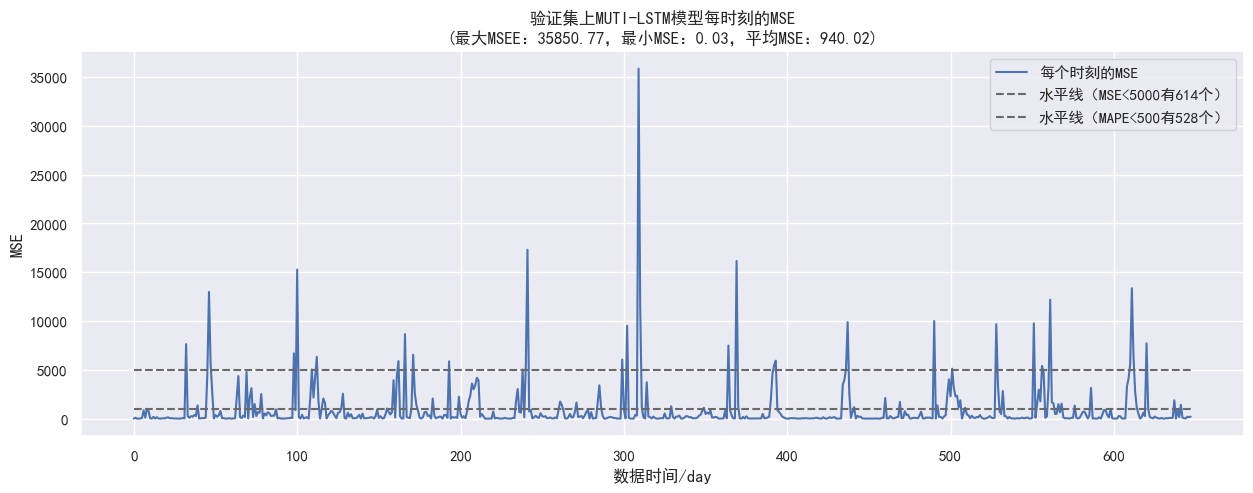

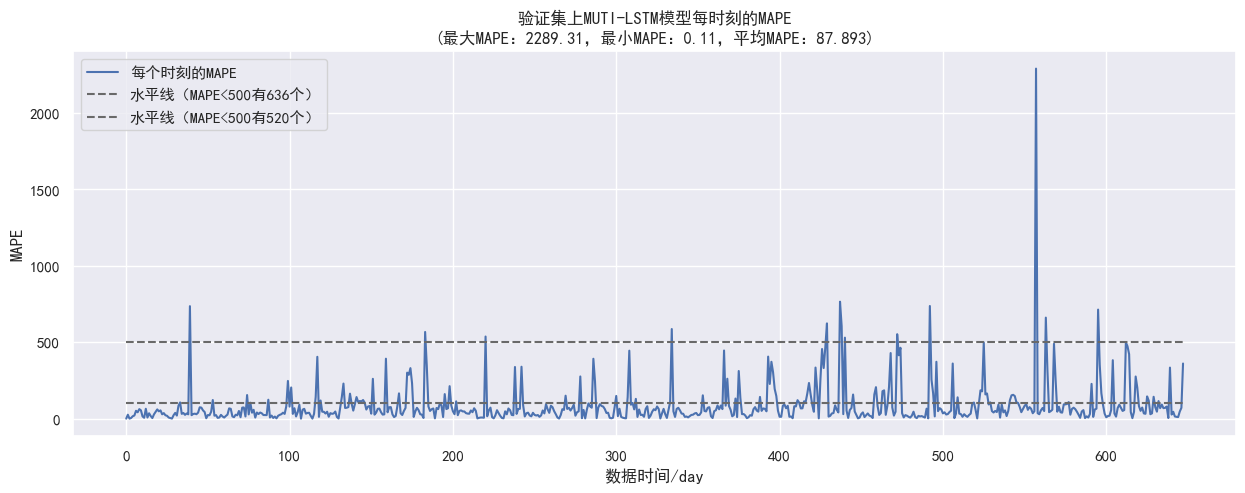

In [41]:

def final_process(regioncode,itemcode,test_size,results):
    
    # 日期转换
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    for i in range(test_size):
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

    # # 判断能用的线条
    # accepted_results = []
    # for r in results:
    #     if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    #     (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
    #         accepted_results.append(r)
    # len(accepted_results)

    # 绘图
    accuracies = [calculate_accuracy(data['ord_qty'].values, r[:-test_size]) for r in results]

    plt.figure(figsize = (15, 5))
    for no, r in enumerate(results):
        plt.plot(r, label = 'forecast %d'%(no + 1))
    plt.plot(data['ord_qty'], label = 'true trend', c = 'black')
    plt.title('LSTM average accuracy: %.4f'%np.mean(accuracies))

    x_range_future = np.arange(len(results[0]))
    plt.xticks(x_range_future[::100], date_ori[::100],rotation=30)
    plt.legend()
    plt.show()

    # 评估 results[i]&data['ord_qty']
    index=np.argmax(accuracies)
    result=results[index]
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    MSE = np.square((data['ord_qty']-result[:-test_size]))
    x1=[5000 for i in range(len(MSE))]
    x2=[1000 for i in range(len(MSE))]
    print(max(MSE))
    print(min(MSE))
    print(np.mean(MSE))
    print(sum(i<1000 for i in MSE))
    
    plt.figure(figsize = (15, 5))
    plt.plot(MSE,label='每个时刻的MSE')
    plt.plot(x1,'--',color='dimgray',label='水平线（MSE<5000有614个）')
    plt.plot(x2,'--',color='dimgray',label='水平线（MAPE<500有528个）')
    plt.xlabel('数据时间/day')
    plt.ylabel('MSE')
    plt.title('验证集上MUTI-LSTM模型每时刻的MSE\n(最大MSEE：35850.77，最小MSE：0.03，平均MSE：940.02)')
    plt.legend()

    MAPE = np.abs((data['ord_qty']-result[:-test_size])/data['ord_qty'])*100
    x1=[500 for i in range(len(MAPE))]
    x2=[100 for i in range(len(MAPE))]
    # print(sum(i<100 for i in MAPE))
    plt.figure(figsize = (15, 5))
    plt.plot(MAPE,label='每个时刻的MAPE')
    plt.plot(x1,'--',color='dimgray',label='水平线（MAPE<500有636个）')
    plt.plot(x2,'--',color='dimgray',label='水平线（MAPE<500有520个）')
    plt.xlabel('数据时间/day')
    plt.ylabel('MAPE')
    plt.title('验证集上MUTI-LSTM模型每时刻的MAPE\n(最大MAPE：2289.31，最小MAPE：0.11，平均MAPE：87.893)')
    plt.legend()

final_process(rcode,icode,test_size,results) 
    




simulation 1
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


train loop: 100%|██████████| 150/150 [00:54<00:00,  2.74it/s, acc=91.1, cost=0.0166]

simulation 2


train loop: 100%|██████████| 150/150 [00:53<00:00,  2.81it/s, acc=91.3, cost=0.0154]


simulation 3


train loop: 100%|██████████| 150/150 [00:50<00:00,  2.94it/s, acc=90.2, cost=0.0193]

simulation 4


train loop: 100%|██████████| 150/150 [00:51<00:00,  2.94it/s, acc=91.2, cost=0.0159]


simulation 5


train loop: 100%|██████████| 150/150 [00:50<00:00,  2.97it/s, acc=91, cost=0.0167]  


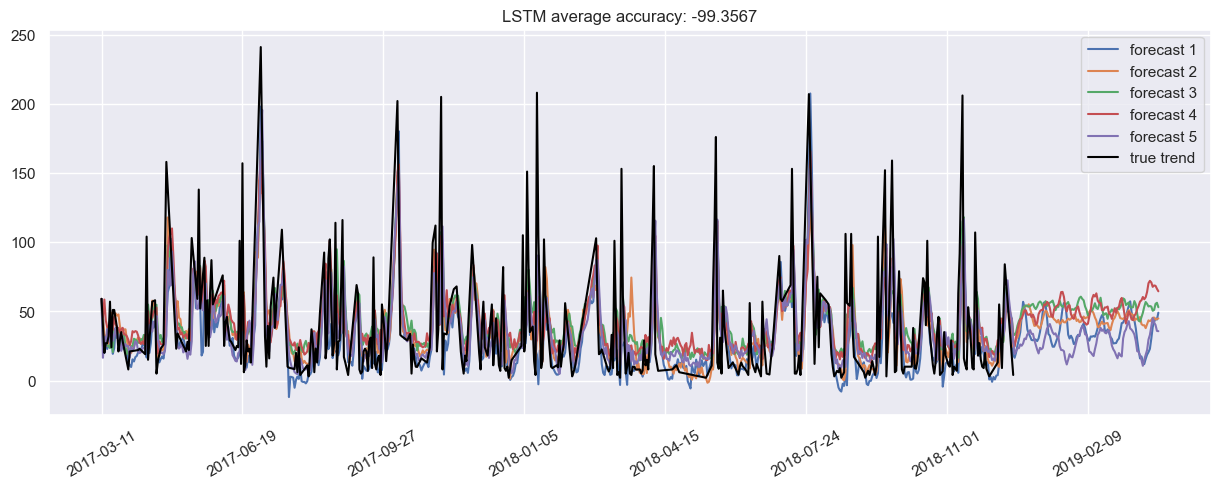

NameError: name 'metrics' is not defined

In [20]:
outcomes=[]

rcode=101
icode=20739

# 数据提取
data=ori_data[(ori_data['item_code']==icode)&(ori_data['sales_region_code']==rcode)]

# 数据预处理
# 将同一天的数据进行合并
# 缺失数据进行补充
exday=pd.to_datetime(data.iloc[0,0])+pd.Timedelta(days=-1)

exqty=0
exprice=0
alist=[]
for index,row in data.iterrows():
    day=(pd.to_datetime(row['order_date'])-exday).days
    if day>1:
        # 缺失日补充
        qty=(row['ord_qty']-exqty)/day
        price=(row['item_price']-exprice)/day
        for i in range(day-1):
            date=exday+pd.Timedelta(days=(i+1))
            value=[date,0,0,0,0,0,exprice+price*(i+1),exqty+qty*(i+1),0,0]
            alist.append(value)
    else:
        if day==0:
            # 同一天数据进行合并
            row['item_price']=(row['item_price']+exprice)/2
            row['ord_qty']=(row['ord_qty']+exqty)/2
    exday=pd.to_datetime(row['order_date'])
    exqty=row['ord_qty']
    exprice=row['item_price']
# 删除同一日数据
data=data.drop_duplicates(subset=['order_date'],keep='last')
# 日期排序
data1=pd.DataFrame(alist,columns=data.columns)
data=pd.concat([data,data1],axis=0)
data['order_date']=pd.to_datetime(data['order_date'])
data=data.sort_values(by='order_date',ascending=True)
data.reset_index(drop=True, inplace=True) # 重新排序

# Y特征处理&提取
minmax = MinMaxScaler().fit(data.iloc[:, 7:8]) # ord_qty
df_log = minmax.transform(data.iloc[:, 7:8]) # ord_qty
df_log = pd.DataFrame(df_log)
df_log.head()
df_train=df_log

# 变量设置
test_size=(pd.to_datetime("2019/03/31")-pd.to_datetime(data.iloc[-1,0])).days
future_day = test_size

# 模拟运算
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

# 画图&结果存储

final_process(rcode,icode,test_size,results) 



